In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

import feature_engine.imputation as mdi

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Table of contents
1. [Read Data](#read_data)
2. [Nulls](#nulls)
    1. [Frequencies](#frequencies)
    2. [Multiple Imputation by Chained Equations](#mice)
    3. [Imputation pipeline](#imputation_pipe)
3. [Encoding](#encoding)
    1. [Ordinal encoding](#oe)
    2. [Replace categories with frequency of observation](#fo)
    3. [Encoding with integers in a ordered manner](#encode_ordered)
    4. [Encoding with mean of target](#encode_mean)
    5. [Encoding with Weight of Evidence](#encode_woe)
4. [Numerical transformation (distribution)](#num_transformation)
    1. [Transforming variables with the logarithm](#log)
    2. [Transforming variables with the reciprocal function](#rec)
    3. [Transform with square and cube root](#sqrt_cbrt)
    4. [Using power tranformations](#power_transformation)
    5. [Box-Cox transformation](#box-cox)
5. [Variable discretization](#discretization)
    1. [Equal-width discretization](#ew_disc)
    2. [Equal frequency discretization](#ef_disc)
    3. [Discretization followed by categorical encoding](#disc_encoding)
    4. [K-means clustering discretization](#clust_disc)
    5. [Decision tree clustering discretization](#tree_disc)
6. [Outliers](#outliers)
    1. [Identification](#out_identification)
    2. [Winsorization](#winsorization)
    3. [Capping](#capping)
7. [Feature Scaling](#scaling)
    1. [Standard Scaler](#standard_scaler)
    2. [Mean normalization](#mean_scaler)
    3. [Min-max scaling](#min_max_scaler)
    4. [Absolute scaling](#absolute_scaler)
8. [Mathematical computations](#math)
    1. [Statistical operations](#statistical)
    2. [Polynomial expansion](#polynomial)
    3. [Deriving new features with decision trees](#new_feat_tree)
    4. [Principal Component Analysis](#pca)

## <a id="read_data"></a> Read Data

In [ ]:
path = (Path('..') / 'Kaggle-Titanic-Spacechip-Competion')

In [ ]:
train_data = pd.read_csv(path / 'train.csv')
test_data = pd.read_csv(path / 'test.csv')

In [ ]:
train_data.info()

In [ ]:
data_num = train_data.select_dtypes(include=['int', 'float']).sample(25, random_state=4)
data_cat = train_data.select_dtypes(include=['object']).sample(25, random_state=4)
data_cat = data_cat.fillna(method='ffill')

y = train_data.iloc[data_num.index].Transported

In [ ]:
train_data.describe()

In [ ]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(10,2))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

## Nulls <a id="nulls"></a>

In [ ]:
train_data.isnull().sum()

In [ ]:
print(train_data.select_dtypes(include='object').nunique())
print(f'\nlen: {len(train_data)}')

### Frequencies <a id="frequencies"></a>

In [ ]:
for col in train_data.select_dtypes(include='object').columns.difference(['PassengerId', 'Cabin', 'Name']):
    print(train_data[col].value_counts()/len(train_data), '\n')

In [ ]:
train_data.hist(bins=30, figsize=(20,8), density=True)
plt.show()

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(y=train_data['Spa'])

### Multiple Imputation by Chained Equations <a id="mice"></a>

In [ ]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
imputer_bay = IterativeImputer(estimator=BayesianRidge(), max_iter=10)
data_bay = imputer_bay.fit_transform(data_num)
pd.DataFrame(data_bay, columns=imputer_bay.get_feature_names_out())

In [ ]:
imputer_kn = IterativeImputer(estimator=KNeighborsRegressor(), max_iter=10)
data_kn = imputer_kn.fit_transform(data_num)
df_kn = pd.DataFrame(data_kn, columns=imputer_kn.get_feature_names_out())
df_kn.VRDeck.mean()

In [ ]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=5),
    max_iter=10,
    random_state=0)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(
        max_features='sqrt', random_state=0),
    max_iter=10,
    random_state=0)

imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(
        n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0)

In [ ]:
X_train_bayes = imputer_bayes.fit_transform(data_num)
X_train_knn = imputer_knn.fit_transform(data_num)
X_train_nonLin = imputer_nonLin.fit_transform(data_num)
X_train_missForest = imputer_missForest.fit_transform(data_num)

X_train_bayes = pd.DataFrame(X_train_bayes, columns=imputer_bayes.get_feature_names_out())
X_train_knn = pd.DataFrame(X_train_knn, columns=imputer_knn.get_feature_names_out())
X_train_nonLin = pd.DataFrame(X_train_nonLin, columns=imputer_nonLin.get_feature_names_out())
X_train_missForest = pd.DataFrame(X_train_missForest, columns=imputer_missForest.get_feature_names_out())

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)


data_num['FoodCourt'].plot(kind='kde', ax=ax, color='blue')
X_train_bayes['FoodCourt'].plot(kind='kde', ax=ax, color='green')
X_train_knn['FoodCourt'].plot(kind='kde', ax=ax, color='red')
X_train_nonLin['FoodCourt'].plot(kind='kde', ax=ax, color='black')
X_train_missForest['FoodCourt'].plot(kind='kde', ax=ax, color='orange')

### Imputation pipeline <a id="imputation_pipe"></a>

In [ ]:
features_num_arbitrary = ['VRDeck','ShoppingMall']
features_num_kn = ['Age', 'RoomService']
features_num_median = ['Spa','FoodCourt']

#### sklearn

In [ ]:
# Imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
imputer_num_arbitrary = Pipeline(steps=[
                                 ('imputer', SimpleImputer(strategy='constant', fill_value=327)),
])
imputer_num_kn = Pipeline(steps=[
                                 ('imputer', IterativeImputer(estimator=KNeighborsRegressor(), max_iter=10)),
])
imputer_num_median = Pipeline(steps=[
                                 ('imputer', SimpleImputer(strategy='median')),
])

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('imp_num_arbitraty', imputer_num_arbitrary, features_num_arbitrary),
    ('imp_num_kn', imputer_num_kn, features_num_kn),
    ('imp_num_median', imputer_num_median, features_num_median),
], remainder='passthrough')

In [ ]:
pd.DataFrame(preprocessor.fit_transform(data_num), columns=preprocessor.get_feature_names_out())

#### feature_engine

In [ ]:
# Imports
import feature_engine.imputation as mdi

In [ ]:
# Feature-engine imputers
imp_num_arbitrary = mdi.ArbitraryNumberImputer(arbitrary_number=-999)
imp_num_kn = mdi.MeanMedianImputer(imputation_method='mean')

# Scikit-learn imputer
imp_num_median = SimpleImputer(strategy='median')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('imp_num_arbitrary', imp_num_arbitrary, features_num_arbitrary),
        ('imp_num_kn', imp_num_kn, features_num_kn),
        ('imp_num_median', imp_num_median, features_num_median)
    ],
    remainder='passthrough'  # Keeps the rest of the columns unchanged
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [ ]:
pd.DataFrame(pipe.fit_transform(data_num), columns=pipe.get_feature_names_out())

### Categorical Imputation

In [ ]:
# Imports
from feature_engine.imputation import CategoricalImputer

In [ ]:
imputer = CategoricalImputer(
    fill_value="missing"
)

In [ ]:
imputer = CategoricalImputer(
    imputation_method="frequent"
)

## Encoding <a id="encoding"></a>

### Ordinal encoding <a id="oe"></a>

In [ ]:
# Imports
from sklearn.preprocessing import OrdinalEncoder as sk_oe
from feature_engine.encoding import OrdinalEncoder as fe_oe

In [ ]:
vars_to_oe = ['HomePlanet','Destination']

oe = sk_oe()

encoded = pd.DataFrame(oe.fit_transform(data_cat[vars_to_oe]), columns=oe.get_feature_names_out())
encoded.index = data_cat.index

pd.concat([data_cat, encoded], axis=1)

### Replace categories with frequency of observation <a id="fo"></a>

In [ ]:
# Imports
from feature_engine.encoding import CountFrequencyEncoder

In [ ]:
count_map = data_cat['Destination'].value_counts().to_dict()
print(count_map)

In [ ]:
count_enc = CountFrequencyEncoder(encoding_method='count', variables=vars_to_oe, missing_values='ignore') # or encoding_method='frequency'

In [ ]:
data_frequency = count_enc.fit_transform(data_cat)

### Encoding with integers in a ordered manner <a id="encode_ordered"></a>
Good for linear models

In [ ]:
# Imports
from feature_engine.encoding import OrdinalEncoder

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

train_data.groupby(['HomePlanet'])['Transported'].mean().plot(ax=axes[0], title='HomePlanet vs Transported')
train_data.groupby(['Destination'])['Transported'].mean().plot(ax=axes[1], title='Destination vs Transported')

plt.tight_layout()
plt.show()

In [ ]:
ordinal_enc = OrdinalEncoder(encoding_method='ordered', variables=['HomePlanet','Destination'], missing_values='ignore')
data_ordinal = ordinal_enc.fit_transform(data_cat, y)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

pd.concat([data_ordinal, y], axis=1).groupby(['HomePlanet'])['Transported'].mean().plot(ax=axes[0], title='HomePlanet vs Transported')
pd.concat([data_ordinal, y], axis=1).groupby(['Destination'])['Transported'].mean().plot(ax=axes[1], title='Destination vs Transported')

plt.tight_layout()
plt.show()

### Encoding with mean of target <a id="encode_mean"></a>

In [ ]:
# Imports
from feature_engine.encoding import MeanEncoder

In [ ]:
data_cat.info()

In [ ]:
variables=['HomePlanet','Destination']

mean_enc = MeanEncoder(variables=variables)
a = mean_enc.fit_transform(data_cat, y)

In [ ]:
data_mean = mean_enc.fit_transform(data_cat, y)
data_mean

### Encoding with Weight of Evidence <a id="encode_woe"></a>

In [ ]:
# Imports
from feature_engine.encoding import WoEEncoder

In [ ]:
woe_enc = WoEEncoder(variables=['HomePlanet','Destination'])

In [ ]:
# data_woe = woe_enc.fit_transform(data_cat, y)
# data_woe

## Numerical transformation (distribution) <a id="num_transformation"></a>

### Transforming variables with the logarithm <a id="log"></a>

In [ ]:
# Imports
from sklearn.preprocessing import FunctionTransformer
from feature_engine.transformation import LogTransformer

In [ ]:
data_tf = data_num.copy()

data_tf = np.log(data_num+1e-9)

In [ ]:
diagnostic_plots(data_num, 'ShoppingMall')

In [ ]:
diagnostic_plots(data_tf, 'ShoppingMall')

In [ ]:
# "Scales" the data as well

In [ ]:
transformer = FunctionTransformer(lambda x: np.log(x + 1e-9))

data_tf = transformer.transform(data_num)

pd.DataFrame(data_tf)

### Transforming variables with the reciprocal function (1/x) <a id="rec"></a>

In [ ]:
# Imports
from feature_engine.transformation import ReciprocalTransformer

In [ ]:
data_rec = np.reciprocal(data_num + 1e-1)

In [ ]:
diagnostic_plots(data_num, 'ShoppingMall')

In [ ]:
diagnostic_plots(data_rec, 'ShoppingMall')

In [ ]:
transformer = FunctionTransformer(lambda x: np.reciprocal(x + 1e-1))
data_rec = transformer.transform(data_num)

In [ ]:
# Does not work because of the 0s

# rt = ReciprocalTransformer()
# data_rec = rt.fit_transform(data)

### Transform with square and cube root <a id="sqrt_cbrt"></a>

In [ ]:
data_tf = data_num.copy()

In [ ]:
data_tf_sqrt = np.sqrt(data_num)
data_tf_cbrt = np.cbrt(data_num)

In [ ]:
diagnostic_plots(data_num, 'ShoppingMall')

In [ ]:
diagnostic_plots(data_tf_sqrt, 'ShoppingMall')

In [ ]:
diagnostic_plots(data_tf_cbrt, 'ShoppingMall')

### Using power tranformations <a id="power_transformation"></a>

In [ ]:
# Imports
from feature_engine.transformation import PowerTransformer

In [ ]:
data_pt = data_num.copy()

In [ ]:
pt = PowerTransformer(exp=0.23)
df_pt = pt.fit_transform(data_pt)

In [ ]:
diagnostic_plots(df_pt, 'ShoppingMall')

### Box-Cox transformation <a id="box-cox"></a>

In [ ]:
# Imports
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from feature_engine.transformation import BoxCoxTransformer, PowerTransformer

In [ ]:
data_bc = data_num.copy()

data_bc = data_bc+1e-5

In [ ]:
# data_bc['FoodCourt'], param = stats.boxcox(data_bc['FoodCourt'])
# print('Optimal λ: ', param)

In [ ]:
diagnostic_plots(data_num, 'ShoppingMall')

In [ ]:
diagnostic_plots(data_bc, 'ShoppingMall')

In [ ]:
transformer = PowerTransformer(method='box-cox', standardize=True)

In [ ]:
array_bc = transformer.fit_transform(data_bc)
df_bc = pd.DataFrame(array_bc, columns=transformer.get_feature_names_out())

In [ ]:
diagnostic_plots(df_bc, 'ShoppingMall')

In [ ]:
transformer = PowerTransformer(method='yeo-johnson', standardize=True)

array_yj = transformer.fit_transform(data_bc)
df_yj = pd.DataFrame(array_yj, columns=transformer.get_feature_names_out())

diagnostic_plots(df_yj, 'FoodCourt')

In [ ]:
transformer.lambdas_

## Variable discretization <a id="discretization"></a>

In [ ]:
data = train_data.select_dtypes(include=['int', 'float']).sample(25, random_state=25)

data = data.fillna(method='bfill')

data

In [ ]:
data_disc = data.copy()

### Equal-width discretization <a id="ew_disc"></a>

In [ ]:
# Imports
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualWidthDiscretiser

In [ ]:
ew_disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

ew_disc = EqualWidthDiscretiser(bins=10)

ew_df = ew_disc.fit_transform(data_disc)

In [ ]:
diagnostic_plots(data_disc, 'FoodCourt')

In [ ]:
diagnostic_plots(ew_df, 'FoodCourt')

### Equal frequency discretization <a id="ef_disc"></a>

In [ ]:
# Imports
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualFrequencyDiscretiser

In [ ]:
ef_disc = EqualFrequencyDiscretiser(q=10)

In [ ]:
ef_df = ef_disc.fit_transform(data_disc)

In [ ]:
diagnostic_plots(data_disc, 'ShoppingMall')

In [ ]:
diagnostic_plots(ef_df, 'ShoppingMall')

### Discretization followed by categorical encoding <a id="disc_encoding"></a>

Doing this will make it so that the mean o the target variable is ordered on all variables

Good for linear models

In [ ]:
# Imports
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

In [ ]:
ef_disc = EqualFrequencyDiscretiser(q=10, return_object=True)

In [ ]:
ef_df = ef_disc.fit_transform(data_disc)

In [ ]:
y.index = ef_df.index

plt.figure(figsize=(4,3))
pd.concat([ef_df, y],axis=1).groupby('Transported').mean().plot()
plt.ylabel('mean')
plt.show()

In [ ]:
enc = OrdinalEncoder(encoding_method = 'ordered')
encoded = enc.fit_transform(ef_df, y)

In [ ]:
y.index = encoded.index

plt.figure(figsize=(2,3))
pd.concat([encoded, y],axis=1).groupby('Transported').mean().plot()
plt.ylabel('mean')
plt.show()

### K-means clustering discretization <a id="clust_disc"></a>

In [ ]:
# Imports
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
kb_disc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
kb_df = kb_disc.fit_transform(data_disc)
kb_df = pd.DataFrame(kb_df, columns=kb_disc.get_feature_names_out())

In [ ]:
kb_df

In [ ]:
diagnostic_plots(kb_df, 'Spa')

### Decision tree clustering discretization <a id="tree_disc"></a>

In [ ]:
# Imports
from feature_engine.discretisation import DecisionTreeDiscretiser

In [ ]:
tree_disc = DecisionTreeDiscretiser(cv=10,
                                   scoring='accuracy',
                                   regression=False, param_grid={'max_depth': [1,2,3,4]})

In [ ]:
dt_df = tree_disc.fit_transform(data_disc, y)
dt_df = pd.DataFrame(dt_df, columns=tree_disc.get_feature_names_out())

In [ ]:
tree_disc.binner_dict_['ShoppingMall'].best_estimator_

In [ ]:
dt_df

In [ ]:
diagnostic_plots(dt_df, 'ShoppingMall')

In [ ]:
y.index = dt_df.index

plt.figure(figsize=(4,3))
pd.concat([dt_df, y],axis=1).groupby('Transported').mean().plot()
plt.ylabel('mean')
plt.show()

## Outliers <a id="outliers"></a>

### Identification <a id="out_identification"></a>

In [ ]:
def find_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    upper_bound = df[variable].quantile(0.75) + (IQR*distance)
    lower_bound = df[variable].quantile(0.25) - (IQR*distance)

    return upper_bound, lower_bound

upper_bound, lower_bound = find_boundaries(train_data, 'Spa', 3)
upper_bound, lower_bound

In [ ]:
outliers = np.where(train_data.Spa > upper_bound, True,
                    np.where(train_data.Spa < lower_bound, True, False))

In [ ]:
train_data.loc[outliers, 'Spa']

In [ ]:
train_data.select_dtypes(include=['int', 'float']).max() - train_data.select_dtypes(include=['int', 'float']).min()

In [ ]:
train_data.isnull().sum().sort_values(ascending=True)

### Winsorization <a id="winsorization"></a>

In [ ]:
# Imports
from feature_engine.outliers import Winsorizer

In [ ]:
winsorizer = Winsorizer(tail='both', capping_method='quantiles', )
wins_df = winsorizer.fit_transform(data_num)

In [ ]:
diagnostic_plots(data_num, 'ShoppingMall')

In [ ]:
diagnostic_plots(wins_df, 'ShoppingMall')

In [ ]:
winsorizer.left_tail_caps_

In [ ]:
winsorizer.right_tail_caps_

### Capping <a id="capping"></a>

In [ ]:
winsorizer_2 = Winsorizer(tail='both', capping_method='gaussian', fold=3)
wins_df_2 = winsorizer_2.fit_transform(data_num)

In [ ]:
diagnostic_plots(wins_df_2, 'ShoppingMall')

In [ ]:
winsorizer_2.left_tail_caps_

In [ ]:
winsorizer_2.right_tail_caps_

## Feature Scaling <a id="scaling"></a>

### Standard Scaler <a id="standard_scaler"></a>

In [ ]:
# Imports
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler_df = scaler.fit_transform(data_num)
scaler_df = pd.DataFrame(scaler_df, columns=scaler.get_feature_names_out())

In [ ]:
diagnostic_plots(data_num, 'ShoppingMall')

In [ ]:
diagnostic_plots(scaler_df, 'ShoppingMall')

### Mean normalization <a id="mean_scaler"></a>

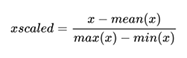

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [ ]:
scaler_mean = StandardScaler(with_mean=True, with_std=False)
scaler_minmax = RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0, 100))

In [ ]:
scaler_mean.fit(data_num)
scaler_minmax.fit(data_num)

scaled = scaler_minmax.transform(scaler_mean.transform(data_num))
scaled_df = pd.DataFrame(scaled, columns=scaler_minmax.get_feature_names_out())

In [ ]:
diagnostic_plots(scaled_df, 'VRDeck')

### Min-max scaling <a id="min_max_scaler"></a>

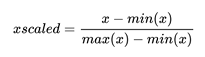

In [ ]:
# Imports
from sklearn.preprocessing import MinMaxScaler

In [ ]:
min_max_scaler = MinMaxScaler()
min_max_df = min_max_scaler.fit_transform(data_num)
min_max_df = pd.DataFrame(min_max_df, columns=min_max_scaler.get_feature_names_out())

In [ ]:
diagnostic_plots(min_max_df, 'VRDeck')

### Absolute scaling <a id="absolute_scaler"></a>

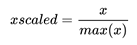

In [ ]:
# Imports
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
absolute_scaler = MaxAbsScaler()
absolute_df = absolute_scaler.fit_transform(data_num)
absolute_df = pd.DataFrame(absolute_df, columns=absolute_scaler.get_feature_names_out())

In [ ]:
diagnostic_plots(absolute_df, 'VRDeck')

## Mathematical computations <a id="math"></a>

### Statistical operations <a id="statistical"></a>

In [ ]:
df_t = data_num.agg(['sum','prod','mean','std', 'max', 'min'], axis='columns')
df_t

In [ ]:
y.index = df_t.index

df_t_concat = pd.concat([df_t, y],axis=1)

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.violinplot(x="Transported", y="std", data=df_t_concat)
plt.subplot(1, 2, 2)
sns.violinplot(x="Transported", y="mean", data=df_t_concat)
plt.show()

### Polynomial expansion <a id="polynomial"></a>

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree=3, interaction_only=False,include_bias=False)

poly_df = poly.fit_transform(data_num[['Spa', 'VRDeck', 'RoomService']])
poly_df = pd.DataFrame(poly_df, columns=poly.get_feature_names_out())

In [ ]:
poly_df

In [ ]:
def plot_features(df, target):
    nb_rows = 5
    nb_cols = 4
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(12, 12))
    plt.subplots_adjust(wspace=None, hspace=0.4)
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            if n!=19:
                axs[i, j].scatter(df[df.columns[n]], target)
                axs[i, j].set_title(df.columns[n])
                n += 1
    plt.show()

In [ ]:
plot_features(poly_df, y)

### Deriving new features with decision trees <a id="new_feat_tree"></a>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'max_depth': [3, 4, None]}

tree_model = GridSearchCV(DecisionTreeClassifier(random_state=0),
                          cv = 5,
                          scoring = 'accuracy',
                          param_grid = param_grid)

In [ ]:
tree_model.fit(data_num[['Spa', 'VRDeck', 'RoomService']], y)

In [ ]:
data_num['new_feat'] = tree_model.predict(data_num[['Spa', 'VRDeck', 'RoomService']])

In [ ]:
pd.concat([data_num, y], axis=1)

In [ ]:
plt.scatter(data_num['new_feat'], y)
plt.ylabel('Transported')
plt.xlabel('new_feat')

### Principal Component Analysis <a id="pca"></a>

In [ ]:
# Imports
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=None)

pca_df = pca.fit_transform(data_num)
pca_df = pd.DataFrame(pca_df, columns=pca.get_feature_names_out())

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Percentage of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Variance Explained')

In [ ]:
pca_df

In [ ]:
diagnostic_plots(pca_df, 'pca4')